In [3]:
import gc
import tensorflow as tf

tf.keras.backend.clear_session()
import gc

gc.collect()


985

In [2]:
from tensorflow.keras import backend as K
K.clear_session()

In [3]:
print(tf.config.list_physical_devices())
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense ,Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
%matplotlib inline 
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

In [5]:
import os
import random
import shutil

In [39]:
# Define the original directories
real_dir = r"C:\dataset deepfake images\Train\Real"
fake_dir = r"C:\dataset deepfake images\Train\Fake"

In [8]:

# Define the new base directory for the split dataset
base_dir = r"E:\Datasets\deep_fake_split"
os.makedirs(base_dir, exist_ok=True)

In [8]:
# Create the subdirectories
dirs = ['train', 'test', 'valid']
categories = ['Real', 'Fake']

In [8]:
for dir_name in dirs:
    for category in categories:
        os.makedirs(os.path.join(base_dir, dir_name, category), exist_ok=True)

In [9]:
# Function to copy images to a specific directory
def copy_images(src_dir, dest_dir, images):
    for image in images:
        shutil.copy(os.path.join(src_dir, image), os.path.join(dest_dir, image))

In [10]:
# Function to split and move data
def split_data(src_dir, train_size, test_size, valid_size):
    images = [img for img in os.listdir(src_dir) if img.endswith(('jpg', 'jpeg', 'png'))]
    random.shuffle(images)
    
    train_images = images[:train_size]
    test_images = images[train_size:train_size + test_size]
    valid_images = images[train_size + test_size:train_size + test_size + valid_size]
    
    return train_images, test_images, valid_images

In [11]:
# Define the number of images for each subset based on total size of 20,000 images
train_size = 14000  # 70% of the data
test_size = 3000    # 15% of the data
valid_size = 3000   # 15% of the data

In [16]:
# Split and copy images for Real
real_train_images, real_test_images, real_valid_images = split_data(real_dir, train_size, test_size, valid_size)
copy_images(real_dir, os.path.join(base_dir, 'train', 'Real'), real_train_images)
copy_images(real_dir, os.path.join(base_dir, 'test', 'Real'), real_test_images)
copy_images(real_dir, os.path.join(base_dir, 'valid', 'Real'), real_valid_images)

# Split and copy images for Fake
fake_train_images, fake_test_images, fake_valid_images = split_data(fake_dir, train_size, test_size, valid_size)
copy_images(fake_dir, os.path.join(base_dir, 'train', 'Fake'), fake_train_images)
copy_images(fake_dir, os.path.join(base_dir, 'test', 'Fake'), fake_test_images)
copy_images(fake_dir, os.path.join(base_dir, 'valid', 'Fake'), fake_valid_images)

print("Data split into train/test/valid successfully.")


Data split into train/test/valid successfully.


In [10]:
train_dir = r"C:\dataset deepfake images\Train"
valid_dir = r"C:\dataset deepfake images\Validation"
test_dir = r"C:\dataset deepfake images\Test"

In [11]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    classes=['Real', 'Fake'],  
    batch_size=20,
    class_mode='binary'  # Set class_mode to binary for sigmoid
)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_dir,
    target_size=(224, 224),
    classes=['Real', 'Fake'],  
    batch_size=20,
    class_mode='binary'  # Set class_mode to binary for sigmoid
)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    classes=['Real', 'Fake'],  
    batch_size=20,
    class_mode='binary',  # Set class_mode to binary for sigmoid
    shuffle=False  
)


Found 20000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [45]:
print(train_batches.class_indices)

{'Real': 0, 'Fake': 1}


[1. 0. 1. 1. 1.]


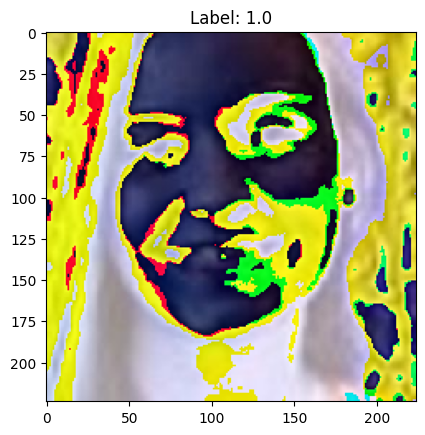

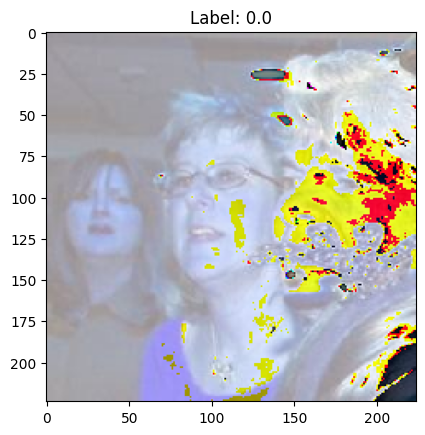

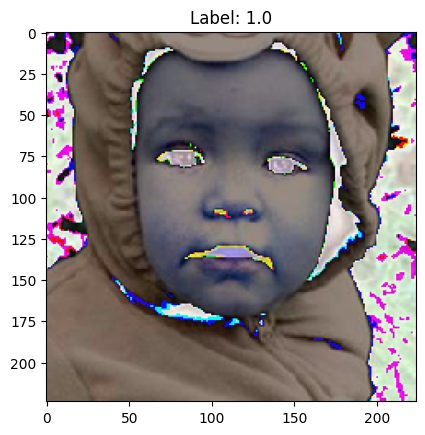

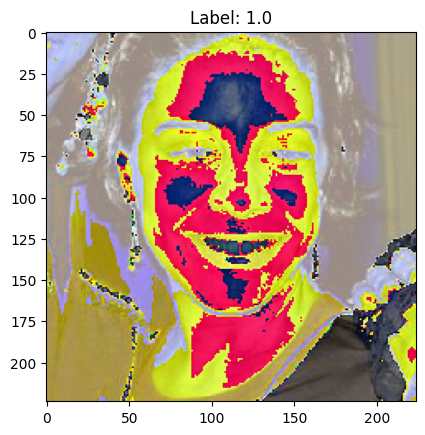

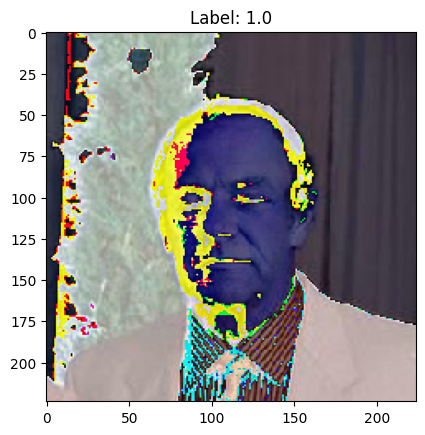

In [48]:
# Get a batch of training data (images and labels)
images, labels = next(train_batches)

# Check the first 5 labels
print(labels[:5])  # Print the first 5 labels in the batch

# Optionally, display the corresponding images to confirm
import matplotlib.pyplot as plt

for i in range(5):  # Show first 5 images with labels
    plt.imshow(images[i].astype("uint8"))  # Display the image
    plt.title(f"Label: {labels[i]}")  # Display the label
    plt.show()

In [47]:
# Check class distribution in the training dataset
train_class_counts = train_batches.classes
print(f"Number of Real images: {sum(train_class_counts == 0)}")
print(f"Number of Fake images: {sum(train_class_counts == 1)}")

Number of Real images: 10000
Number of Fake images: 10000


In [49]:
# Get a few batches from the generator
for i in range(3):
    images, labels = next(train_batches)
    print(f"Batch {i+1} labels: {labels}")

Batch 1 labels: [0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.]
Batch 2 labels: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1.]
Batch 3 labels: [1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.]


In [42]:
with tf.device('/CPU:0'):
    vgg16_base = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))

In [43]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [50]:
# Freeze the convolutional base
vgg16_base.trainable = False

In [51]:
# Build the Sequential model
model = tf.keras.Sequential([
    vgg16_base,                              # VGG16 base model (pre-trained)
    Flatten(),                               # Flatten the output of the VGG16
    Dense(units=256, activation='relu'),     # First Dense layer
    Dropout(0.3),                            # Dropout to reduce overfitting
    Dense(units=128, activation='relu'),     # Second Dense layer
    Dropout(0.3),                            # Another Dropout layer
    Dense(units=1, activation='sigmoid')     # Single output unit with sigmoid for binary classification
])

In [52]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [54]:

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [55]:
history = model.fit(
    train_batches,               
    validation_data=valid_batches,
    epochs=20,                     
    batch_size=20,                
    callbacks=[early_stopping]  
)

Epoch 1/20
1000/1000 [==============================] - 202s 200ms/step - loss: 0.8025 - accuracy: 0.7472 - val_loss: 0.3787 - val_accuracy: 0.8380
Epoch 2/20
1000/1000 [==============================] - 193s 193ms/step - loss: 0.3681 - accuracy: 0.8447 - val_loss: 0.4028 - val_accuracy: 0.8422
Epoch 3/20
1000/1000 [==============================] - 187s 187ms/step - loss: 0.2722 - accuracy: 0.8857 - val_loss: 0.4099 - val_accuracy: 0.8353
Epoch 4/20
1000/1000 [==============================] - 188s 188ms/step - loss: 0.2124 - accuracy: 0.9183 - val_loss: 0.3734 - val_accuracy: 0.8655
Epoch 5/20
1000/1000 [==============================] - 186s 186ms/step - loss: 0.1685 - accuracy: 0.9391 - val_loss: 0.4357 - val_accuracy: 0.8590
Epoch 6/20
1000/1000 [==============================] - 186s 186ms/step - loss: 0.1313 - accuracy: 0.9534 - val_loss: 0.5055 - val_accuracy: 0.8553
Epoch 7/20
1000/1000 [==============================] - 186s 186ms/step - loss: 0.1181 - accuracy: 0.9585 - val_

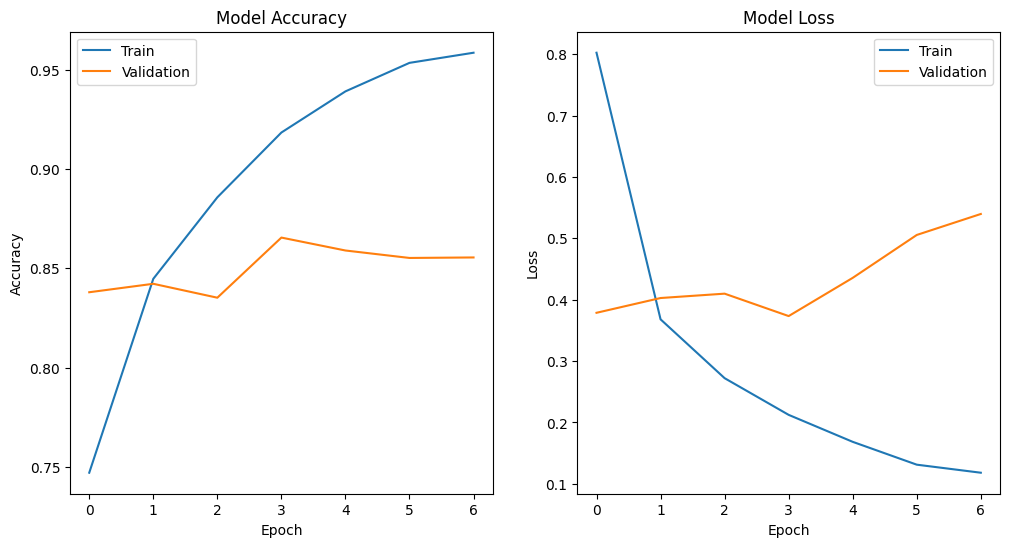

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


In [57]:
model.save('models/fake_image_vgg16_model_V1.h5')
print("Model saved as '/20000_fake_image_vgg16_model.h5'")

Model saved as '/20000_fake_image_vgg16_model.h5'


In [58]:
test_batches.class_indices

{'Real': 0, 'Fake': 1}

In [60]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_batches, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

200/200 [==============================] - 33s 164ms/step - loss: 0.7739 - accuracy: 0.7635
Test Loss: 0.7738890051841736
Test Accuracy: 0.7634999752044678


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import os

# Load your trained model (assuming the model is saved as 'deepfake_model.h5')
model = tf.keras.models.load_model('models/fake_image_vgg16_model_V1.h5')

# Function to preprocess and predict a single image
def predict_image(img_path):
    # Load the image with target size (224, 224)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Add batch dimension (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image for VGG16
    img_array = preprocess_input(img_array)
    
    # Predict using the loaded model
    prediction = model.predict(img_array)
    
    # Return the predicted class label
    if prediction > 0.42:  # Sigmoid output, 0 for Real, 1 for Fake
        return 'Fake', prediction[0][0]
    else:
        return 'Real', prediction[0][0]

# Function to predict multiple images
def predict_multiple_images(image_paths):
    results = []
    for img_path in image_paths:
        label, confidence = predict_image(img_path)
        results.append((os.path.basename(img_path), label, confidence))
    return results

# Example usage: Predict for 5 image paths
image_paths = [
    r"C:\dataset deepfake images\Test\Fake\fake_71.jpg",
    r"C:\dataset deepfake images\Test\Fake\fake_1933.jpg",
    r"C:\dataset deepfake images\Test\Fake\fake_1961.jpg",
    r"C:\dataset deepfake images\Test\Real\real_11.jpg",
    r"C:\dataset deepfake images\Test\Real\real_1978.jpg"
]

# Get predictions
predictions = predict_multiple_images(image_paths)

# Print results
for img_name, label, confidence in predictions:
    print(f"Image: {img_name} | Predicted Label: {label} | Confidence: {confidence:.4f}")


1/1 [==============================] - 0s 32ms/step
Image: fake_71.jpg | Predicted Label: Fake | Confidence: 0.4431
Image: fake_1933.jpg | Predicted Label: Fake | Confidence: 0.4496
Image: fake_1961.jpg | Predicted Label: Real | Confidence: 0.3281
Image: real_11.jpg | Predicted Label: Real | Confidence: 0.0058
Image: real_1978.jpg | Predicted Label: Real | Confidence: 0.0288


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import os

# Load your trained model from the models directory
model = tf.keras.models.load_model('models/fake_image_vgg16_model_V1.h5')

# Function to preprocess and predict a single image
def predict_single_image(img_path):
    # Load the image with target size (224, 224)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Add batch dimension (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image for VGG16
    img_array = preprocess_input(img_array)
    
    # Predict using the loaded model
    prediction = model.predict(img_array)
    
    # Return the predicted class label
    if prediction > 0.3:  # Sigmoid output, 0 for Real, 1 for Fake
        return 'Fake', prediction[0][0]
    else:
        return 'Real', prediction[0][0]

# Example usage: Predict for a single image
image_path = r"C:\dataset deepfake images\Test\Fake\fake_1961.jpg" 

# Get prediction
label, confidence = predict_single_image(image_path)

# Print results
print(f"Image: {os.path.basename(image_path)} | Predicted Label: {label} | Confidence: {confidence:.4f}")


1/1 [==============================] - 0s 200ms/step
Image: fake_1961.jpg | Predicted Label: Fake | Confidence: 0.3281


In [5]:
test_dir = r"C:\dataset deepfake images\Test"

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    classes=['Real', 'Fake'],  # Update classes
    batch_size=20,
    shuffle=False  # For evaluation, set shuffle to False
)


Found 4000 images belonging to 2 classes.


In [6]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import os

# Load your trained model from the models directory
model = tf.keras.models.load_model('models/fake_image_vgg16_model_V1.h5')

# Function to preprocess and predict a batch of test images
def predict_test_images(test_batches):
    # Get ground truth labels
    y_true = test_batches.classes
    
    # Get class labels (e.g., 0: 'Real', 1: 'Fake')
    class_labels = list(test_batches.class_indices.keys())
    
    # Predict probabilities for test images
    y_pred_prob = model.predict(test_batches, verbose=1)
    
    # Convert predicted probabilities to binary class labels based on a threshold
    threshold = 0.5  # You can experiment with this threshold
    y_pred = (y_pred_prob > threshold).astype(int)
    
    # Flatten predicted classes to match ground truth shape
    y_pred = y_pred.flatten()
    
    return y_true, y_pred, class_labels

# Evaluate model on the test set
y_true, y_pred, class_labels = predict_test_images(test_batches)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


200/200 [==============================] - 36s 117ms/step
Accuracy: 0.7635
Precision: 0.8310
Recall: 0.6615
F1 Score: 0.7366

Classification Report:
              precision    recall  f1-score   support

        Real       0.72      0.87      0.79      2000
        Fake       0.83      0.66      0.74      2000

    accuracy                           0.76      4000
   macro avg       0.77      0.76      0.76      4000
weighted avg       0.77      0.76      0.76      4000


Confusion Matrix:
[[1731  269]
 [ 677 1323]]


Accuracy: 76.35%:
The model correctly classifies about 76% of the images overall, which means it's performing reasonably well but there is still room for improvement.

Precision (Real: 0.72, Fake: 0.83):

For "Real" images, 72% of the images classified as "Real" are actually real.
For "Fake" images, 83% of the images classified as "Fake" are truly fake. This suggests the model is more confident when predicting "Fake" images.
Recall (Real: 0.87, Fake: 0.66):

For "Real" images, the model correctly identifies 87% of the actual real images, meaning it is good at detecting real images.
For "Fake" images, the model only correctly identifies 66% of actual fake images. It misses around 34% of fake images, meaning it struggles more in catching fake images.
F1 Score (Real: 0.79, Fake: 0.74):

The F1 score is the harmonic mean of precision and recall. A score close to 1 indicates strong performance. The "Real" class has a slightly better F1 score (0.79) than the "Fake" class (0.74), meaning the model performs slightly better in detecting real images.

Confusion Matrix
True Positives (Real: 1731, Fake: 1323):
The model correctly identifies 1,731 "Real" images and 1,323 "Fake" images.
False Positives (Real: 269, Fake: 677):
269 images were wrongly classified as "Fake" when they were actually real.
677 images were wrongly classified as "Real" when they were actually fake.

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to preprocess and predict a batch of test images
def predict_test_images_with_threshold(test_batches, threshold=0.4):  # Adjust the threshold here
    # Get ground truth labels
    y_true = test_batches.classes
    
    # Get class labels (e.g., 0: 'Real', 1: 'Fake')
    class_labels = list(test_batches.class_indices.keys())
    
    # Predict probabilities for test images
    y_pred_prob = model.predict(test_batches, verbose=1)
    
    # Convert predicted probabilities to binary class labels based on the threshold
    y_pred = (y_pred_prob > threshold).astype(int)
    
    # Flatten predicted classes to match ground truth shape
    y_pred = y_pred.flatten()
    
    return y_true, y_pred, class_labels

# Evaluate model on the test set with threshold 0.4
y_true, y_pred, class_labels = predict_test_images_with_threshold(test_batches, threshold=0.4)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


200/200 [==============================] - 24s 121ms/step
Accuracy: 0.7670
Precision: 0.8062
Recall: 0.7030
F1 Score: 0.7511

Classification Report:
              precision    recall  f1-score   support

        Real       0.74      0.83      0.78      2000
        Fake       0.81      0.70      0.75      2000

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000


Confusion Matrix:
[[1662  338]
 [ 594 1406]]
